In [2]:
# Read libraries and data. Split data into train and test set using 80-20 proportion.
rm(list = ls())
library(dplyr)
library(magrittr)
library(purrr)
library(pROC)
library(xgboost)
library(Matrix)
library(caret)
library(glmnet)
library(reshape2)
library(stargazer)
library(hdi)
library(ggplot2)

data_0 = read.csv('../data/data_clean.csv')
data_0$af_ind = ifelse(data_0$race == "African-American", 1, 0)
data_0$total_past[is.na(data_0$total_past)] <- 0

X = cbind(data_0[, c('age', 'juv_fel_count', "juv_misd_count", 'juv_other_count', 'total_past', "sex_female",
                     "mariage_Divorced", "mariage_Married", "mariage_Separated",
                     "mariage_Significant.Other", "mariage_Unknown", "mariage_Widowed","af_ind")],
          data_0[, 57:827]
          )
Y = data_0$is_recid

# Standardize age and add quadratic term
X$age = scale(X$age)
X$age2 = X$age^2

# Drop duplicated columns to avoid perfect multicollinearity
duplicated_cols <- duplicated(as.list(X), MARGIN = 2)
X <- X[, !duplicated_cols]

# Keep only chapters with at least 2 non-zero entries
X <- X[, colSums(X != 0, na.rm = TRUE) >= 2]

# Split data into train and test set (80-20 proportion)
set.seed(2025)
id_split = runif(length(Y)) > 0.8
Y_train = Y[!id_split]
Y_test = Y[id_split]
X_train = X[!id_split, ]
X_test = X[id_split, ]
data_train = data_0[!id_split, ]
data_test = data_0[id_split, ]




Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘purrr’


The following object is masked from ‘package:magrittr’:

    set_names


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loaded glmnet 4.1-8


Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 


Loading required package: scalreg

Loading required package: lars

Loaded lar

Max Test AUC along path: 0.7357 at k=152 covariates (lambda=0.006136)


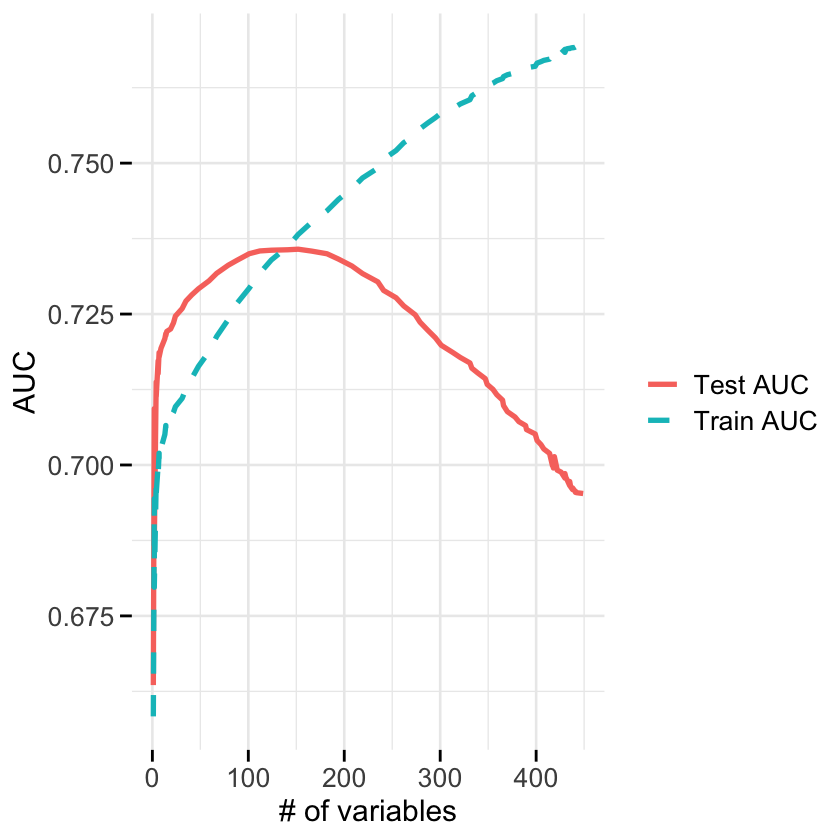

In [49]:
# Figure 4: Training and Test AUC of LASSO-Logit path.
# Fit the LASSO path on training set
lambda_path <- exp(seq(log(1e-4), log(1e-1), length.out = 100))
fit <- glmnet(as.matrix(X_train), Y_train, family = "binomial", alpha = 1, lambda=lambda_path)

# Predict probabilities along the whole path and compute AUCs
P_tr <- predict(fit, newx = as.matrix(X_train), s = lambda_path, type = "response")
P_te <- predict(fit, newx = as.matrix(X_test),  s = lambda_path, type = "response")
train_auc <- apply(P_tr, 2, function(p) as.numeric(auc(roc(Y_train, as.numeric(p), quiet = TRUE))))
test_auc  <- apply(P_te,  2, function(p) as.numeric(auc(roc(Y_test,  as.numeric(p), quiet = TRUE))))

# Number of selected variables at each lambda (exclude intercept)
coef_mat <- as.matrix(coef(fit, s = lambda_path))
var_ct   <- colSums(coef_mat[-1, , drop = FALSE] != 0)

# (Diagnostic) Best test AUC on the path
idx_best <- which.max(test_auc)
cat(sprintf("Max Test AUC along path: %.4f at k=%d covariates (lambda=%.4g)\n",
            test_auc[idx_best], var_ct[idx_best], lambda_path[idx_best]))

# Training and Test AUC of LASSO-Logit path vs #variables
df_plot <- data.frame(var_ct = var_ct, train_auc = train_auc, test_auc = test_auc)

big_axes <- theme_minimal(base_size = 16) +
  theme(
    axis.title  = element_text(size = 18),
    axis.text   = element_text(size = 16),
    axis.ticks  = element_line(linewidth = .8),
    axis.ticks.length = unit(0.25, "cm"),
    legend.text = element_text(size = 16),
    legend.title = element_text(size = 18),
    legend.key.size = unit(1.5, "lines")
  )

ggplot(df_plot, aes(x = var_ct)) +
  geom_line(aes(y = test_auc,  color = "Test AUC"), linewidth = 1.2) +
  geom_line(aes(y = train_auc, color = "Train AUC"), linewidth = 1.2, linetype = "dashed") +
  labs(x = "# of variables", y = "AUC", color = "") +
  big_axes
ggsave("../fig/fig_4.pdf", width = 9, height = 5)


In [3]:
# Table OA.4: Post LASSO-Logit
# Extract variables selected by the best LASSO model and fit post-LASSO model
best_lambda <- lambda_path[idx_best]
best_coef <- coef(fit, s = best_lambda)
selected_vars <- rownames(best_coef)[which(best_coef != 0)]
selected_vars <- selected_vars[selected_vars != "(Intercept)"]  # Remove intercept
formula_str <- paste("Y ~", paste(selected_vars, collapse = " + "))

# Fit post-LASSO logistic regression (unregularized) on the entire sample
post_lasso_model <- glm(formula_str, 
                        data = data.frame(Y, X[, selected_vars, drop = FALSE]), 
                        family = binomial(link = "logit"))

# Model summary
post_lasso_model %>% summary
summary_model <- summary(post_lasso_model)
coefficients <- summary_model$coefficients
significant_coefficients <- coefficients[coefficients[, 4] < 0.1, ]

sig_var_names <- rownames(significant_coefficients)
stargazer(post_lasso_model,
            type = "latex",
            digits = 4,
            star.cutoffs = c(0.1, 0.05, 0.01),
            keep = sig_var_names,
            title = "Post-LASSO Logistic Regression Results (Variables Significant at 1% Level)",
            out = "../tab/tab_oa4.tex")
  

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = formula_str, family = binomial(link = "logit"), 
    data = data.frame(Y, X[, selected_vars, drop = FALSE]))

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -1.343e+00  6.770e-02 -19.837  < 2e-16 ***
age                           -5.558e-01  3.868e-02 -14.367  < 2e-16 ***
juv_other_count                7.086e-02  5.425e-02   1.306 0.191475    
total_past                     8.013e-03  5.841e-03   1.372 0.170138    
sex_female                    -3.808e-01  7.095e-02  -5.366 8.03e-08 ***
mariage_Married               -1.230e-01  9.433e-02  -1.304 0.192225    
mariage_Significant.Other      3.930e-01  1.421e-01   2.765 0.005685 ** 
mariage_Unknown                1.099e-01  4.274e-01   0.257 0.797109    
mariage_Widowed                3.777e-01  4.662e-01   0.810 0.417791    
af_ind                         1.498e-01  5.587e-02   2.681 0.007332 ** 
Theft.Robery_current_M         2.374e-01  1.224e-01 


% Table created by stargazer v.5.2.3 by Marek Hlavac, Social Policy Institute. E-mail: marek.hlavac at gmail.com
% Date and time: Sun, Oct 26, 2025 - 12:47:55
\begin{table}[!htbp] \centering 
  \caption{Post-LASSO Logistic Regression Results (Variables Significant at 1% Level)} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{1}{c}{\textit{Dependent variable:}} \\ 
\cline{2-2} 
\\[-1.8ex] & Y \\ 
\hline \\[-1.8ex] 
 age & $-$0.5558$^{***}$ \\ 
  & (0.0387) \\ 
  & \\ 
 sex\_female & $-$0.3808$^{***}$ \\ 
  & (0.0710) \\ 
  & \\ 
 mariage\_Married & $-$0.1230 \\ 
  & (0.0943) \\ 
  & \\ 
 mariage\_Significant.Other & 0.3930$^{***}$ \\ 
  & (0.1421) \\ 
  & \\ 
 mariage\_Unknown & 0.1099 \\ 
  & (0.4274) \\ 
  & \\ 
 mariage\_Widowed & 0.3777 \\ 
  & (0.4662) \\ 
  & \\ 
 af\_ind & 0.1498$^{***}$ \\ 
  & (0.0559) \\ 
  & \\ 
 Theft.Robery\_current\_M & 0.2374$^{*}$ \\ 
  & (0.1224) \\ 
  & \\ 
 Motor.vehicles\_current\_M & $-$0.2

In [ ]:
# Table 4: Symmetric Classifiers: false positive/negative rates and AUC for Lasso Logit and Boosting.
# 4 minutes to run

# Lasso-Logit with CV.  
model <- cv.glmnet(data.matrix(X_train %>% select(-af_ind)), Y_train,family = binomial(link = 'logit'),alpha = 1,nfolds = 5) 

# Run Lasso Logit with best lambda.
best_lambda <- model$lambda.min

final_model <- glmnet(data.matrix(X_train %>% select(-af_ind)), Y_train, family = binomial(link = 'logit'), alpha = 1, lambda = best_lambda)

# Use this model to predict on test data.
preds <- predict(final_model, data.matrix(X_test %>% select(-af_ind)), type = "response")  
predicted_class <- ifelse(preds > 0.5, 1, 0)

# Calculate confusion matrix and auc for complete test sample
cm <- confusionMatrix(factor(predicted_class),factor(Y_test),  positive = "1")$byClass %>% round(3)
roc_obj <- roc(response = Y_test, predictor = preds, quiet = TRUE)
auc_val <- auc(roc_obj)

a1<-1-cm[2]
a2<-1-cm[1]
a3<-auc_val

# Calculate confusion matrix and auc for african american vs others on test sample
for (r in unique(X_test$af_ind)) {
  idx <- X_test$af_ind == r
  cm_race <- confusionMatrix(factor(predicted_class[idx]),factor(Y_test[idx]), positive = "1")$byClass %>% round(3)
  auc_race <- auc(roc(response = Y_test[idx], predictor = preds[idx], quiet = TRUE)) 
  a1=rbind(a1,1-cm_race[2])
  a2=rbind(a2,1-cm_race[1])
  a3=rbind(a3,auc_race)
}
A1<-cbind(a1,a2,a3)

# Define train and test matrix for xgboost
X_train1 <- data.matrix(as.data.frame(X_train %>% select(-af_ind)))
Y_train1 <- as.numeric(Y_train)
X_test1 <- data.matrix(as.data.frame(X_test %>% select(-af_ind)))
Y_test1 <- as.numeric(Y_test)

dtrain <- xgb.DMatrix(data = X_train1, label = Y_train1)
dtest  <- xgb.DMatrix(data = X_test1,  label = Y_test1)

# define tuning parameter grid for cross validation
param_grid<-expand.grid(eta =c(0.01, 0.1, 1),max_depth = 4,min_child_weight = 1,subsample = 1,colsample_bytree = 1)

# find best set of tuning parameters
best <- list(score = -Inf)

for (i in seq_len(nrow(param_grid))) {
  p <- param_grid[i, ]

  params <- list(objective = "binary:logistic", eval_metric = "auc",eta = p$eta, max_depth = p$max_depth, 
            min_child_weight = p$min_child_weight,subsample = p$subsample,  colsample_bytree = p$colsample_bytree,
            nthread = parallel::detectCores())

  cv <- xgb.cv(params = params,data = dtrain,nrounds = 2000,nfold = 5,verbose = 0, early_stopping_rounds = 100,
    maximize = TRUE)

  if (cv$best_iteration > 0 && cv$evaluation_log$test_auc_mean[cv$best_iteration] > best$score) {
    best <- list(score = cv$evaluation_log$test_auc_mean[cv$best_iteration],iter = cv$best_iteration, params = params)
  }
}

# fit model on best tuning parameter selected by 5 fold CV and  training data
watchlist <- list(train = dtrain, eval = dtest)
xgb_fit <- xgb.train(params = best$params,data = dtrain,nrounds = best$iter,watchlist = watchlist,verbose = 0)

# predict on test data
preds <- predict(xgb_fit, dtest)
predicted_class <- ifelse(preds >= 0.5, 1, 0)

# find overall FPR,FNR and auc
cm <- confusionMatrix(factor(predicted_class),factor(Y_test),  positive = "1")$byClass %>% round(3)
roc_obj <- roc(response = Y_test, predictor = preds, quiet = TRUE)
auc_val <- auc(roc_obj)

a1<-1-cm[2]
a2<-1-cm[1]
a3<-auc_val

#  Find FPR,FNR and auc for african american vs others on test sample
for (r in unique(X_test$af_ind)) {
  idx <- X_test$af_ind == r
  cm_race <- confusionMatrix(factor(predicted_class[idx]),factor(Y_test[idx]), positive = "1")$byClass %>% round(3)
  auc_race <- auc(roc(response = Y_test[idx], predictor = preds[idx], quiet = TRUE)) 
  a1=rbind(a1,1-cm_race[2])
  a2=rbind(a2,1-cm_race[1])
  a3=rbind(a3,auc_race)
}
A2<-cbind(a1,a2,a3)


colnames(A1) <- c('FP', 'FN', 'AUC')
rownames(A1) <- c( 'All', 'Other','African-American')
colnames(A2) <- c('FP', 'FN', 'AUC')
rownames(A2) <- c( 'All', 'Other','African-American')

cat("Logit Lasso:\n")
print(A1)

cat("Boosting:\n")
print(A2)

results_table <- rbind(round(A1, 3), round(A2, 3))
stargazer(results_table,
          type = "latex",
          title = "Classification Performance: Logit Lasso vs Boosting",
          summary = FALSE,
          rownames = TRUE,
          out = "../tab/tab_4.tex")

Warning message in roc.default(response = Y_test, predictor = preds, quiet = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”


Logit Lasso:
                    FP    FN       AUC
All              0.049 0.772 0.7340720
Other            0.026 0.840 0.7330924
African-American 0.075 0.720 0.7190986
Boosting:
                    FP    FN       AUC
All              0.095 0.695 0.7251763
Other            0.055 0.763 0.7358849
African-American 0.143 0.644 0.6970749

% Table created by stargazer v.5.2.3 by Marek Hlavac, Social Policy Institute. E-mail: marek.hlavac at gmail.com
% Date and time: Sun, Oct 26, 2025 - 12:51:52
\begin{table}[!htbp] \centering 
  \caption{Classification Performance: Logit Lasso vs Boosting} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} cccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & FP & FN & AUC \\ 
\hline \\[-1.8ex] 
All & $0.049$ & $0.772$ & $0.734$ \\ 
Other & $0.026$ & $0.840$ & $0.733$ \\ 
African.American & $0.075$ & $0.720$ & $0.719$ \\ 
All.1 & $0.095$ & $0.695$ & $0.725$ \\ 
Other.1 & $0.055$ & $0.763$ & $0.736$ \\ 
African.American.1 & $0.143$ & $0.644$ & $0.697$ \\ 
\hline \\[

In [ ]:
# Penalizing False Negatives More Heavily in Lasso Logit: Asymmetric Classifier
# 12 minutes to run
L_1_1  = 0 # cost of true positive
L_1_m1 = 1 # cost of false positive
L_m1_m1 = 0 # cost of true negative
res_list = matrix(0, nrow = 1, ncol = 9)
L_m1_1_list = c(0.25, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10) # cost of false negative

for (L_m1_1 in L_m1_1_list) {
  
  ax =  L_m1_1 - L_1_1 -  (L_1_m1 - L_m1_m1)
  bx =  L_m1_1 - L_1_1 + L_1_m1 - L_m1_m1
  cx = (L_1_m1 - L_m1_m1) / (L_1_m1 - L_m1_m1 + L_m1_1 - L_1_1)
  w = (ifelse(data_0$is_recid == 1, 1, -1) )*ax + bx
  w_train = w[!id_split]
  w_test = w[id_split]
  
  # 5 fold cross validation Lasso Logit.  

  model <- cv.glmnet(data.matrix(X_train),Y_train,w_train, family = binomial(link = 'logit'),alpha = 1,nfolds = 10) 

   # Run Lasso Logit with best lambda.

  best_lambda <- model$lambda.min
  final_model <- glmnet(data.matrix(X_train),Y_train,w_train, family = binomial(link = 'logit'), alpha = 1, lambda = best_lambda)

  # Use this model to predict on test data.

  preds <- predict(final_model, data.matrix(X_test), type = "response")  
  preds <- as.numeric(preds)
  predicted_class <- ifelse(preds > .5, 1, 0)

  # Calculate confusion matrix and auc for complete test sample

  cm <- confusionMatrix(factor(predicted_class),factor(Y_test),  positive = "1")$byClass %>% round(3)
  roc_obj <- roc(response = Y_test, predictor = preds, quiet = TRUE)
  auc_val <- auc(roc_obj)

  a1<-1-cm[2]
  a1<-cbind(a1,1-cm[1],auc_val)

  # Calculate confusion matrix and auc for african american vs others on test sample


  for (r in unique(X_test$af_ind)) {
     idx <- X_test$af_ind == r
     cm_race <- confusionMatrix(factor(predicted_class[idx]),factor(Y_test[idx]), positive = "1")$byClass %>% round(3)
     auc_race <- auc(roc(response = Y_test[idx], predictor = preds[idx], quiet = TRUE)) 
     a1=cbind(a1,1-cm_race[2],1-cm_race[1],auc_race)
  }
  res_list=rbind(res_list,a1)

  }

res_list<-res_list[-1,]

colnames(res_list) <- c('FP', 'FN', 'AUC','FP', 'FN', 'AUC','FP', 'FN', 'AUC')
rownames(res_list) <- c( 'psi=.25','psi=.5', 'psi=1', 'psi=1.5', 'psi=2', 'psi=2.5', 'psi=3', 'psi=4', 'psi=5', 'psi=6',' psi=7', 'psi=8', 'psi=9', 'psi=10')


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$i

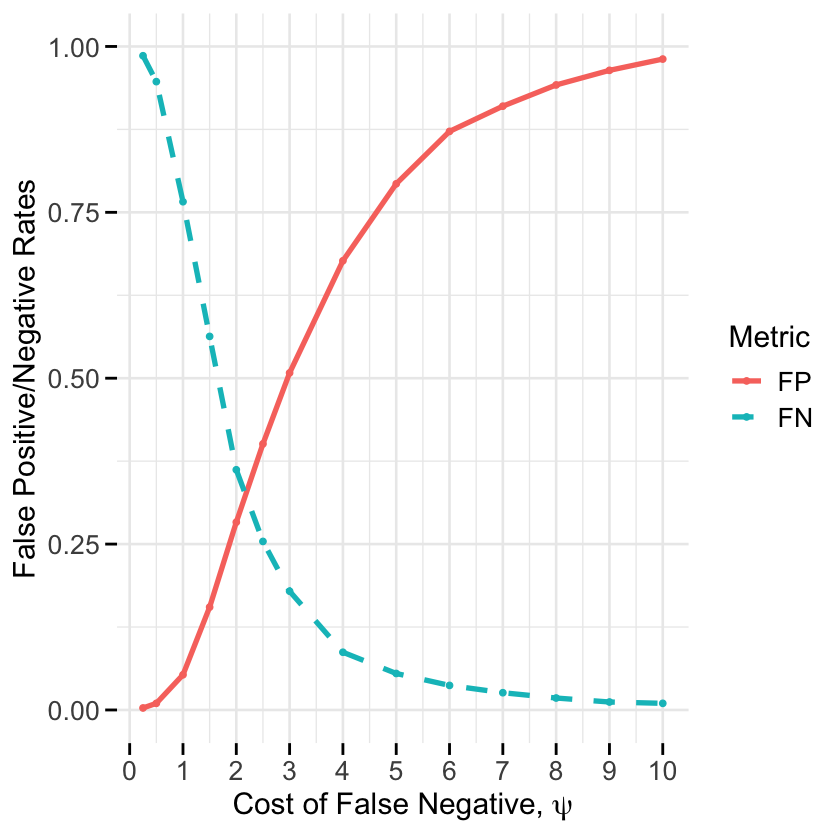

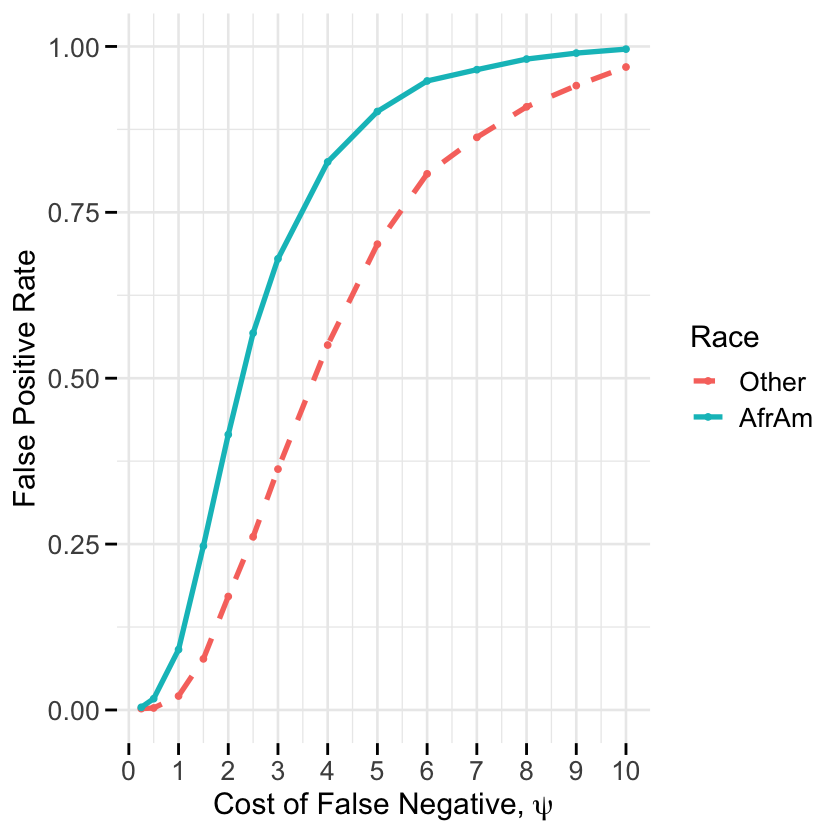

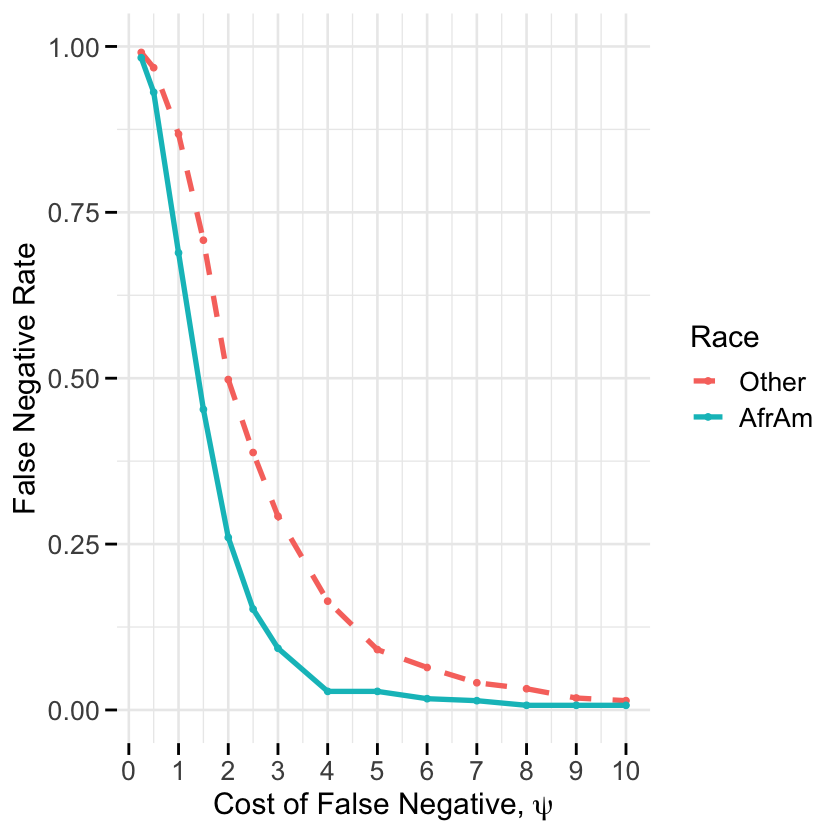

In [6]:
# Figure 5 (a): FP/FN as a function of psi for LASSO-Logit. FP/FN are roughly balanced at psi=2.25
df <- data.frame(
  psi = L_m1_1_list,
  FP  = res_list[, 1],
  FN  = res_list[, 2]
)

df_long <- reshape2::melt(df, id.vars = "psi", variable.name = "metric", value.name = "rate")
ggplot(df_long, aes(x = psi, y = rate, color = metric, linetype = metric)) +
  geom_line(linewidth = 1.5) +
  geom_point() +
  scale_linetype_manual(values = c("FP" = "solid", "FN" = "dashed")) +
  scale_x_continuous(breaks = seq(0, 10)) +
  xlab(expression('Cost of False Negative, '*psi)) +
  ylab('False Positive/Negative Rates') +
  coord_cartesian(ylim = c(0, 1)) +
  labs(color = "Metric", linetype = "Metric") +
  big_axes
ggsave("../fig/fig_5a.pdf", width = 9, height = 6)

# Figure OA.2 (a): group-specific FP as a function of psi for LASSO-Logit
df <- data.frame(
  psi = L_m1_1_list,
  Other = res_list[, 4],
  `AfrAm` = res_list[, 7],
  check.names = FALSE
)
df_long <- reshape2::melt(df, id.vars = "psi", variable.name = "Race", value.name = "rate")
ggplot(df_long, aes(x = psi, y = rate, color = Race, linetype = Race)) +
  geom_line(linewidth = 1.5) +
  geom_point() +
  scale_linetype_manual(values = c("Other" = "dashed", "AfrAm" = "solid")) +
  scale_x_continuous(breaks = seq(0, 10)) +
  xlab(expression('Cost of False Negative, '*psi)) +
  ylab('False Positive Rate') +
  coord_cartesian(ylim = c(0, 1)) +
  big_axes
ggsave("../fig/fig_oa2a.pdf", width = 7, height = 5)

# Figure OA.2 (b): group-specific FN as a function of psi for LASSO-Logit
df <- data.frame(
  psi = L_m1_1_list,
  Other = res_list[, 5],
  `AfrAm` = res_list[, 8],
  check.names = FALSE
)
df_long <- reshape2::melt(df, id.vars = "psi", variable.name = "Race", value.name = "rate")
ggplot(df_long, aes(x = psi, y = rate, color = Race, linetype = Race)) +
  geom_line(linewidth = 1.5) +
  geom_point() +
  scale_linetype_manual(values = c("Other" = "dashed", "AfrAm" = "solid")) +
  scale_x_continuous(breaks = seq(0, 10)) +
  xlab(expression('Cost of False Negative, '*psi)) +
  ylab('False Negative Rate') +
  coord_cartesian(ylim = c(0, 1)) +
  big_axes
ggsave("../fig/fig_oa2b.pdf", width = 7, height = 5)



In [7]:
# Penalizing AF False Positives More Heavily in Lasso Logit: Asymmetric Classifier
# 8 minutes to run
L_1_1  = 0 # cost of true positive
L_1_m1 = 1 # cost of false positive
L_m1_m1 = 0 # cost of true negative

res_list1=  matrix(0, nrow = 1, ncol = 15)
multiplier_list = c(0.5, 0.75, 1, 1.25, 1.50, 1.75, 2, 2.25, 2.5)
L_m1_1 = 2.25 # cost of false negative to achieve balanced rates

af_ind = (data_0$race == "African-American")

for (multiplier in multiplier_list)
{
  L_m1_1_v = rep(L_m1_1, dim(data_0)[1])*ifelse(af_ind == TRUE, 1, 1)
  L_1_m1_v = rep(L_1_m1, dim(data_0)[1])*ifelse(af_ind == TRUE, multiplier, 1)
  ax =  L_m1_1_v - L_1_1 -  (L_1_m1_v - L_m1_m1)
  bx =  L_m1_1_v - L_1_1 + L_1_m1_v - L_m1_m1
  cx = (L_1_m1_v - L_m1_m1) / (L_1_m1_v - L_m1_m1 + L_m1_1_v - L_1_1)
  w = (ifelse(data_0$is_recid == 1, 1, -1) )*ax + bx
  w_train = w[!id_split]
  w_test = w[id_split]
  
  # 5 fold cross validation Lasso Logit.  
  model <- cv.glmnet(data.matrix(X_train),Y_train,w_train, family = binomial(link = 'logit'),alpha = 1,nfolds = 10) 
  
   # Run Lasso Logit with best lambda.
  best_lambda <- model$lambda.min
  final_model <- glmnet(data.matrix(X_train),Y_train,w_train, family = binomial(link = 'logit'), alpha = 1, lambda = best_lambda)

  # Use this model to predict on test data.
  preds <- predict(final_model, data.matrix(X_test), type = "response")  
  preds <- as.numeric(preds)
  predicted_class <- ifelse(preds >= .5, 1, 0)

  # Calculate confusion matrix and auc for complete test sample
  cm <- confusionMatrix(factor(predicted_class),factor(Y_test),  positive = "1")$byClass %>% round(3)
  roc_obj <- roc(response = Y_test, predictor = preds, quiet = TRUE)
  auc_val <- auc(roc_obj)
  a1<-1-cm[2]
  a1<-cbind(a1,1-cm[1],auc_val)

  # Calculate confusion matrix and auc for african american vs others on test sample
  for (r in unique(X_test$af_ind)) {
     idx <- X_test$af_ind == r
     cm_race <- confusionMatrix(factor(predicted_class[idx]),factor(Y_test[idx]), positive = "1")$byClass %>% round(3)
     auc_race <- auc(roc(response = Y_test[idx], predictor = preds[idx], quiet = TRUE)) 
     a1=cbind(a1,1-cm_race[2],1-cm_race[1],auc_race,cm_race[3],cm_race[4],cm_race[11])
  }
  res_list1=rbind(res_list1,a1)

}

res_list1<-res_list1[-1,]

colnames(res_list1) <- c('FP', 'FN', 'AUC','FP', 'FN', 'AUC','PPV','NPV','Accuracy','FP', 'FN', 'AUC','PPV','NPV','Accuracy')
rownames(res_list1) <- c('psi1=.5','psi1=.75', 'psi1=1', 'psi1=1.25', 'psi1=1.5', 'psi1=1.75', 'psi=2', 'psi=2.25', 'psi=2.5')


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$i

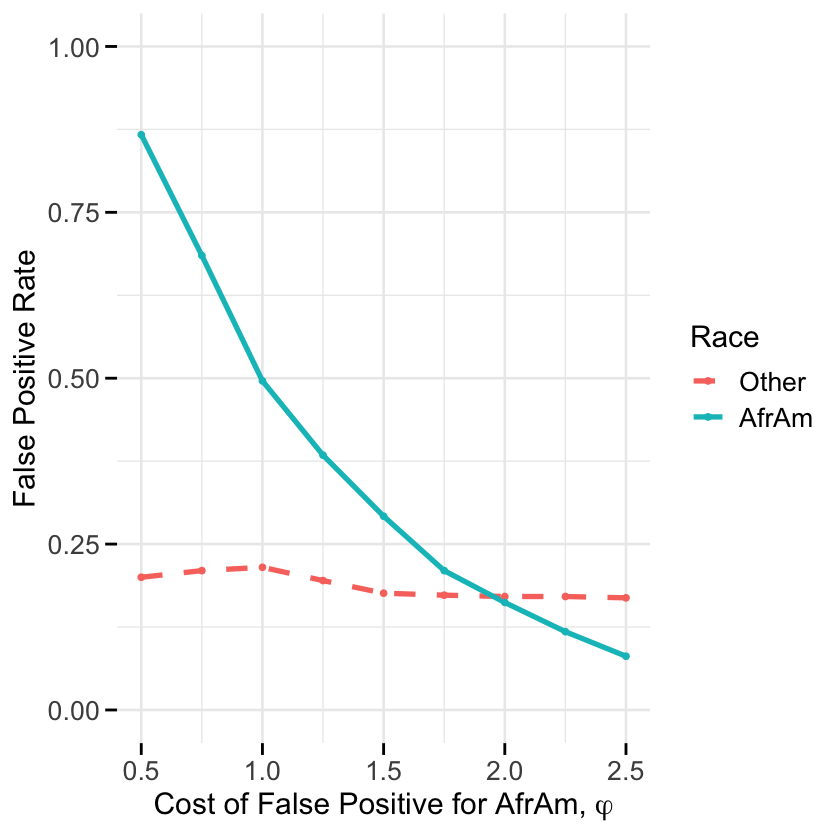

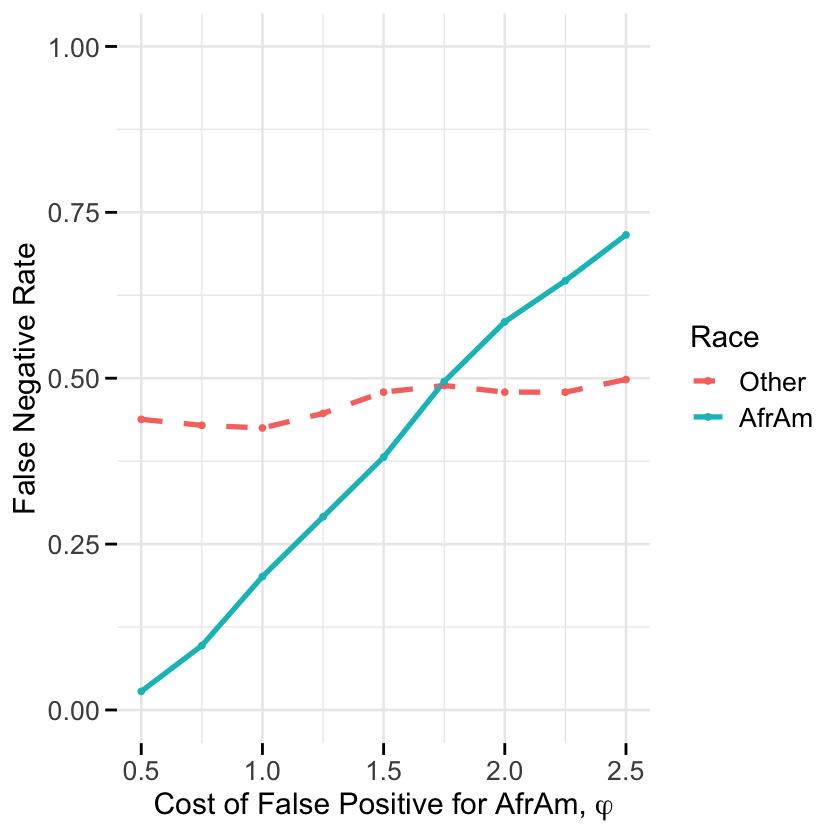

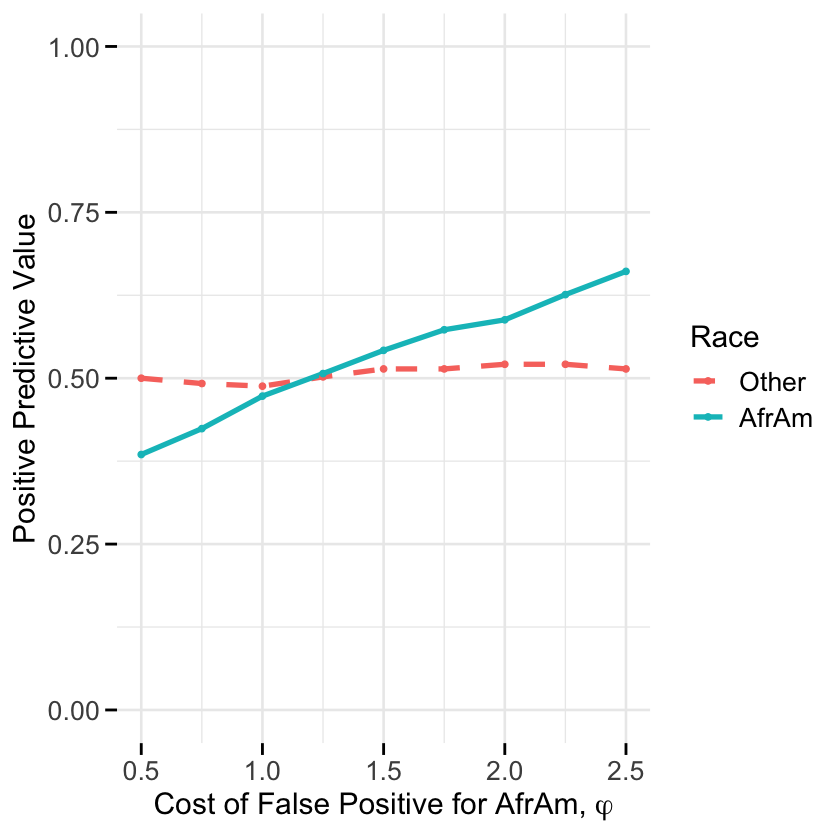

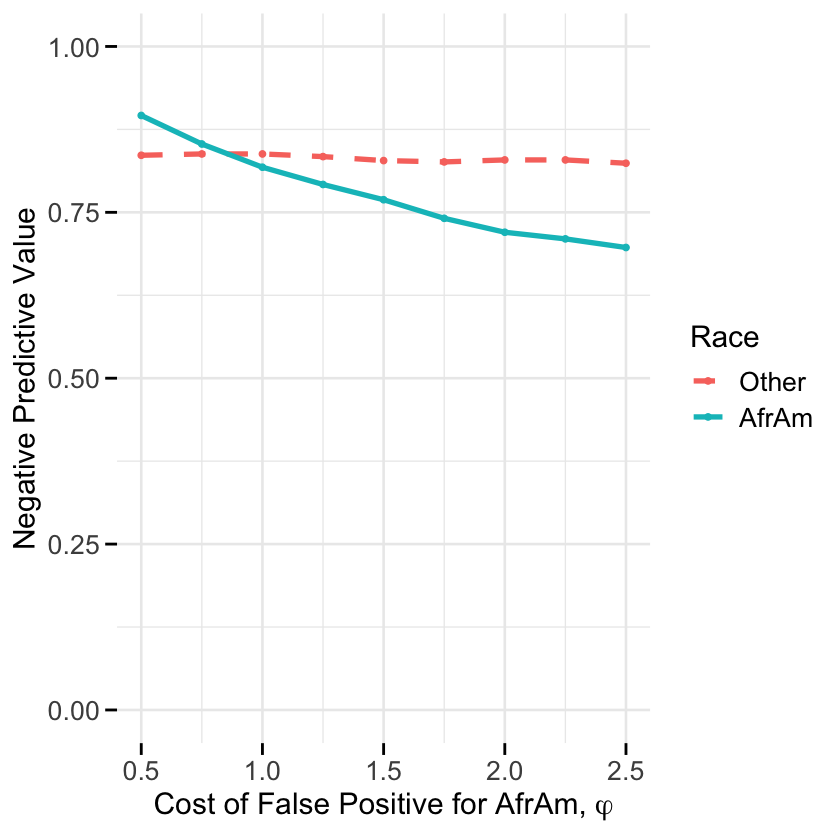

In [8]:
# Figure 6 (a): group-specific FP as a function of psi1 for LASSO-Logit
df <- data.frame(
  psi = multiplier_list,        # cost of false negative
  Other  = res_list1[, 4],
  AfrAm  = res_list1[, 10]
)
df_long <- reshape2::melt(df, id.vars = "psi", variable.name = "Race", value.name = "rate")
ggplot(df_long, aes(x = psi, y = rate, color = Race, linetype = Race)) +
  geom_line(linewidth=1.5) +
  geom_point() +
  scale_linetype_manual(values = c("Other" = "dashed", "AfrAm" = "solid")) +
  xlab(expression('Cost of False Positive for AfrAm, '*phi1)) +
  ylab('False Positive Rate') + 
  coord_cartesian(ylim = c(0, 1)) +
  big_axes
ggsave("../fig/fig_6a.pdf", plot = last_plot(), width = 9, height = 6)


# Figure 6 (b): group-specific FN as a function of psi1 for LASSO-Logit
df <- data.frame(
  psi = multiplier_list,        # cost of false negative
  Other  = res_list1[, 5],
  AfrAm  = res_list1[, 11]
)
df_long <- reshape2::melt(df, id.vars = "psi", variable.name = "Race", value.name = "rate")
ggplot(df_long, aes(x = psi, y = rate, color = Race, linetype = Race)) +
  geom_line(linewidth=1.5) +
  geom_point() +
  scale_linetype_manual(values = c("Other" = "dashed", "AfrAm" = "solid")) +
  xlab(expression('Cost of False Positive for AfrAm, '*phi1)) +
  ylab('False Negative Rate') + 
  coord_cartesian(ylim = c(0, 1)) +
  big_axes
ggsave("../fig/fig_6b.pdf", plot = last_plot(), width = 9, height = 6)

# Figure 7 (a): group-specific positive predictive value as a function of psi1 for LASSO-Logit
df <- data.frame(
  psi =multiplier_list,        # cost of false negative
  Other  = res_list1[, 7],
  AfrAm = res_list1[, 13]
)
df_long <- reshape2::melt(df, id.vars = "psi", variable.name = "Race", value.name = "rate")
ggplot(df_long, aes(x = psi, y = rate, color = Race, linetype = Race)) +
  geom_line(linewidth=1.5) +
  geom_point() +
  scale_linetype_manual(values = c("Other" = "dashed", "AfrAm" = "solid")) +
  xlab(expression('Cost of False Positive for AfrAm, '*phi1)) +
  ylab('Positive Predictive Value') + 
  coord_cartesian(ylim = c(0, 1)) +
  big_axes
ggsave("../fig/fig_7a.pdf", plot = last_plot(), width = 9, height = 6)

# Figure 7 (b): group-specific negative predictive value as a function of psi1 for LASSO-Logit
df <- data.frame(
  psi = multiplier_list,        # cost of false negative
  Other  = res_list1[, 8],
  AfrAm  = res_list1[, 14]
)
df_long <- reshape2::melt(df, id.vars = "psi", variable.name = "Race", value.name = "rate")
ggplot(df_long, aes(x = psi, y = rate, color = Race, linetype = Race)) +
  geom_line(linewidth=1.5) +
  geom_point() +
  scale_linetype_manual(values = c("Other" = "dashed", "AfrAm" = "solid")) +
  xlab(expression('Cost of False Positive for AfrAm, '*phi1)) +
  ylab('Negative Predictive Value') + 
  coord_cartesian(ylim = c(0, 1)) +
  big_axes
ggsave("../fig/fig_7b.pdf", plot = last_plot(), width = 9, height = 6)



In [ ]:
# Penalizing False Positives More Heavily in Boosting: Asymmetric Classifier
# 63 minutes to run
res_list2 = matrix(0, nrow = 1, ncol = 9)
L_m1_1_list = c(0.25, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10) # cost of false negative

# Define train and test matrix for xgboost
X_train1 <- data.matrix(as.data.frame(X_train %>% select(-af_ind)))
Y_train1 <- as.numeric(Y_train)
X_test1 <- data.matrix(as.data.frame(X_test %>% select(-af_ind)))
Y_test1 <- as.numeric(Y_test)
param_grid<-expand.grid(eta =c(0.01, 0.1, 1),max_depth = 4,min_child_weight = 1,subsample = 1,colsample_bytree = 1)
  
for (L_m1_1 in L_m1_1_list) {
  cat(sprintf("Processing L_m1_1 = %.2f\n", L_m1_1))
  ax =  L_m1_1 - L_1_1 -  (L_1_m1 - L_m1_m1)
  bx =  L_m1_1 - L_1_1 + L_1_m1 - L_m1_m1
  cx = (L_1_m1 - L_m1_m1) / (L_1_m1 - L_m1_m1 + L_m1_1 - L_1_1)
  w = (ifelse(data_0$is_recid == 1, 1, -1) )*ax + bx
  w_train = w[!id_split]
  w_test = w[id_split]
  dtrain <- xgb.DMatrix(data = X_train1, label = Y_train1,weight = w_train)
  dtest  <- xgb.DMatrix(data = X_test1,  label = Y_test1,weight = w_test)
  
# find best set of tuning parameters

  best <- list(score = -Inf)

  for (i in seq_len(nrow(param_grid))) {
      p <- param_grid[i, ]

      params <- list(objective = "binary:logistic", eval_metric = "auc",eta = p$eta, max_depth = p$max_depth, min_child_weight = p$min_child_weight,subsample = p$subsample,  colsample_bytree = p$colsample_bytree)

      cv <- xgb.cv(params = params,data = dtrain,nrounds = 2000,nfold = 5,verbose = 0,early_stopping_rounds = 100,
            maximize = TRUE)

      if (cv$best_iteration > 0 && cv$evaluation_log$test_auc_mean[cv$best_iteration] > best$score) {
      best <- list(score = cv$evaluation_log$test_auc_mean[cv$best_iteration],iter = cv$best_iteration, params =             params)
      }
      # fit model on best tuning parameter selected by 5 fold CV and  training data
  }
  watchlist <- list(train = dtrain, eval = dtest)
  xgb_fit <- xgb.train(params = best$params,data = dtrain,nrounds = best$iter,watchlist = watchlist,verbose = 0)

# predict on test data

  preds <- predict(xgb_fit, dtest)
  predicted_class <- ifelse(preds >= .5, 1, 0)

# find overall FPR,FNR and auc

  cm <- confusionMatrix(factor(predicted_class),factor(Y_test),  positive = "1")$byClass %>% round(3)
  roc_obj <- roc(response = Y_test, predictor = preds, quiet = TRUE)
  auc_val <- auc(roc_obj)
  a1<-1-cm[2]
  a1<-cbind(a1,1-cm[1],auc_val)


  for (r in unique(X_test$af_ind)) {
    idx <- X_test$af_ind == r
    cm_race <- confusionMatrix(factor(predicted_class[idx]),factor(Y_test[idx]), positive = "1")$byClass %>% round(3)
    auc_race <- auc(roc(response = Y_test[idx], predictor = preds[idx], quiet = TRUE)) 
    a1=cbind(a1,1-cm_race[2],1-cm_race[1],auc_race)
    }
  res_list2=rbind(res_list2,a1)

  }
res_list2<-res_list2[-1,]

colnames(res_list2) <- c('FP', 'FN', 'AUC','FP', 'FN', 'AUC','FP', 'FN', 'AUC')
rownames(res_list2) <- c('psi=.25','psi=.5','psi=1','psi=1.5','psi=2','psi=2.5','psi=3','psi=4', 'psi=5', 'psi=6',' psi=7', 'psi=8', 'psi=9', 'psi=10')

Processing L_m1_1 = 0.25
Processing L_m1_1 = 0.50
Processing L_m1_1 = 1.00
Processing L_m1_1 = 1.50
Processing L_m1_1 = 2.00
Processing L_m1_1 = 2.50
Processing L_m1_1 = 3.00
Processing L_m1_1 = 4.00
Processing L_m1_1 = 5.00
Processing L_m1_1 = 6.00
Processing L_m1_1 = 7.00
Processing L_m1_1 = 8.00
Processing L_m1_1 = 9.00
Processing L_m1_1 = 10.00


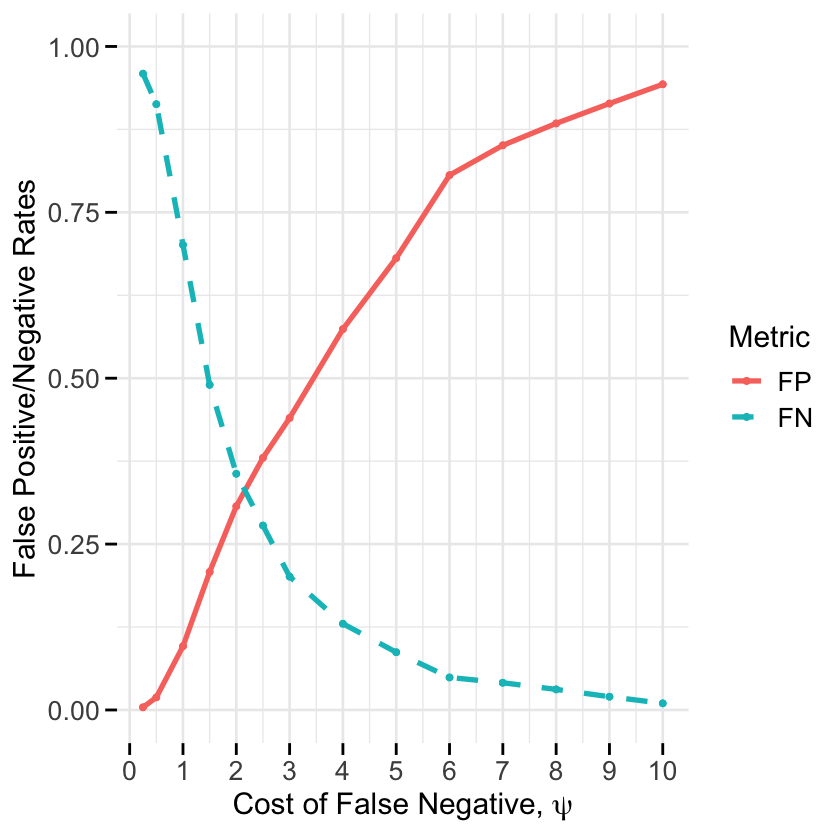

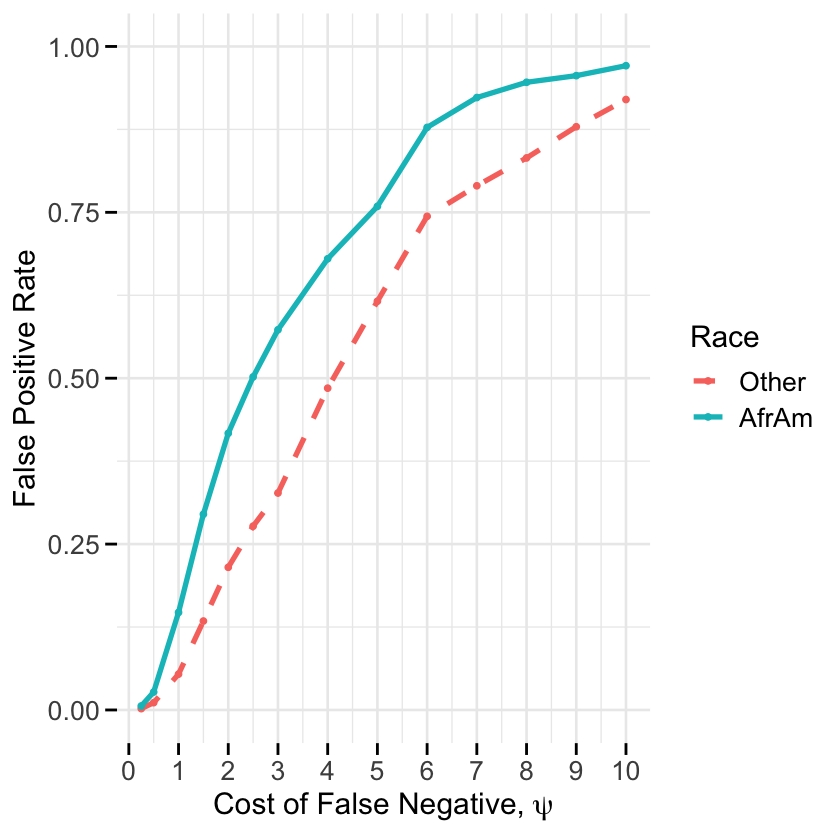

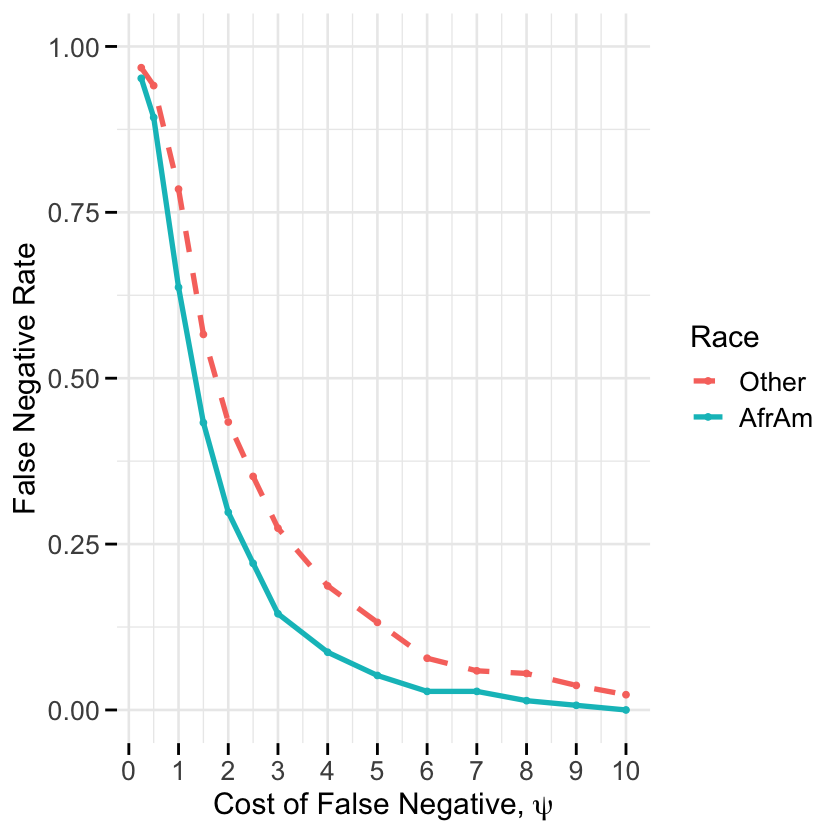

In [10]:
# Figure 5 (b): FP/FN as a function of psi for XGBoost. FP/FN are roughly balanced at psi=2.25
df <- data.frame(
  psi = L_m1_1_list,        # cost of false negative
  FP  = res_list2[, 1],
  FN  = res_list2[, 2]
)
df_long <- reshape2::melt(df, id.vars = "psi", variable.name = "metric", value.name = "rate")
ggplot(df_long, aes(x = psi, y = rate, color = metric, linetype = metric)) +
  geom_line(linewidth = 1.5) +
  geom_point() +
  scale_linetype_manual(values = c("FP" = "solid", "FN" = "dashed")) +
  geom_point() +
  scale_x_continuous(breaks = seq(0, 10)) +
  xlab(expression('Cost of False Negative, '*psi)) +
  ylab('False Positive/Negative Rates') +
  coord_cartesian(ylim = c(0, 1)) +
  labs(color = "Metric", linetype = "Metric") +
  big_axes
ggsave("../fig/fig_5b.pdf", width = 9, height = 6)

# Figure OA.2 (c): group-specific FP as a function of psi for XGBoost
df <- data.frame(
  psi = L_m1_1_list,        # cost of false negative
  Other  = res_list2[, 4],
  `AfrAm`  = res_list2[, 7],
  check.names = FALSE
)
df_long <- reshape2::melt(df, id.vars = "psi", variable.name = "Race", value.name = "rate")
ggplot(df_long, aes(x = psi, y = rate, color = Race, linetype = Race)) +
  geom_line(linewidth = 1.5) +
  geom_point() +
  scale_linetype_manual(values = c("Other" = "dashed", "AfrAm" = "solid")) +
  scale_x_continuous(breaks = seq(0, 10)) +
  xlab(expression('Cost of False Negative, '*psi)) +
  ylab('False Positive Rate') + 
  coord_cartesian(ylim = c(0, 1)) +
  big_axes

ggsave("../fig/fig_oa2c.pdf", plot = last_plot(), width = 7, height = 5)

# Figure OA.2 (d): group-specific FN as a function of psi for XGBoost
df <- data.frame(
  psi = L_m1_1_list,        # cost of false negative
  Other  = res_list2[, 5],
  `AfrAm`  = res_list2[, 8],
  check.names = FALSE
)
df_long <- reshape2::melt(df, id.vars = "psi", variable.name = "Race", value.name = "rate")

ggplot(df_long, aes(x = psi, y = rate, color = Race, linetype = Race)) +
  geom_line(linewidth = 1.5) +
  geom_point() +
  scale_linetype_manual(values = c("Other" = "dashed", "AfrAm" = "solid")) +
  scale_x_continuous(breaks = seq(0, 10)) +
  xlab(expression('Cost of False Negative, '*psi)) +
  ylab('False Negative Rate') + 
  coord_cartesian(ylim = c(0, 1)) +
  big_axes
ggsave("../fig/fig_oa2d.pdf", plot = last_plot(), width = 7, height = 5)



In [ ]:
# Penalizing AF False Positive More Heavily in Boosting: Asymmetric Classifier
# 38 minutes to run
X_train1 <- data.matrix(as.data.frame(X_train))
Y_train1 <- as.numeric(Y_train)
X_test1 <- data.matrix(as.data.frame(X_test))
Y_test1 <- as.numeric(Y_test)

L_1_1  = 0 # cost of true positive
L_1_m1 = 1 # cost of false positive
L_m1_m1 = 0 # cost of true negative

res_list3=  matrix(0, nrow = 1, ncol = 15)

multiplier_list = c(0.5, 0.75, 1, 1.25, 1.50, 1.75, 2, 2.25, 2.5)
L_m1_1 = 2.25 # cost of false negative

af_ind = (data_0$race == "African-American")

for (multiplier in multiplier_list)
{
  L_m1_1_v = rep(L_m1_1, dim(data_0)[1])*ifelse(af_ind == TRUE, 1, 1)
  L_1_m1_v = rep(L_1_m1, dim(data_0)[1])*ifelse(af_ind == TRUE, multiplier, 1)
  ax =  L_m1_1_v - L_1_1 -  (L_1_m1_v - L_m1_m1)
  bx =  L_m1_1_v - L_1_1 + L_1_m1_v - L_m1_m1
  cx = (L_1_m1_v - L_m1_m1) / (L_1_m1_v - L_m1_m1 + L_m1_1_v - L_1_1)
  w = (ifelse(data_0$is_recid == 1, 1, -1) )*ax + bx
  w_train = w[!id_split]
  w_test = w[id_split]
  dtrain <- xgb.DMatrix(data = X_train1, label = Y_train1,weight = w_train)
  dtest  <- xgb.DMatrix(data = X_test1,  label = Y_test1,weight = w_test)

# define tuning parameter grid for cross validation

  param_grid<-expand.grid(eta =c(0.01, 0.1, 1),max_depth = 4,min_child_weight = 1,subsample = 1,colsample_bytree = 1)
  
# find best set of tuning parameters

  best <- list(score = -Inf)

  for (i in seq_len(nrow(param_grid))) {
      p <- param_grid[i, ]

      params <- list(objective = "binary:logistic", eval_metric = "auc",eta = p$eta, max_depth = p$max_depth, min_child_weight = p$min_child_weight,subsample = p$subsample,  colsample_bytree = p$colsample_bytree)

      cv <- xgb.cv(params = params,data = dtrain,nrounds = 2000,nfold = 5,verbose = 0,early_stopping_rounds = 100,
            maximize = TRUE)

      if (cv$best_iteration > 0 && cv$evaluation_log$test_auc_mean[cv$best_iteration] > best$score) {
      best <- list(score = cv$evaluation_log$test_auc_mean[cv$best_iteration],iter = cv$best_iteration, params =             params)
      }
      # fit model on best tuning parameter selected by 5 fold CV and  training data
  }
  watchlist <- list(train = dtrain, eval = dtest)
  xgb_fit <- xgb.train(params = best$params,data = dtrain,nrounds = best$iter,watchlist = watchlist,verbose = 0)

# predict on test data

  preds <- predict(xgb_fit, dtest)
  predicted_class <- ifelse(preds >= .5, 1, 0)

# find overall FPR,FNR and auc

  cm <- confusionMatrix(factor(predicted_class),factor(Y_test),  positive = "1")$byClass %>% round(3)
  roc_obj <- roc(response = Y_test, predictor = preds, quiet = TRUE)
  auc_val <- auc(roc_obj)
  a1<-1-cm[2]
  a1<-cbind(a1,1-cm[1],auc_val)

 for (r in unique(X_test$af_ind)) {
     idx <- X_test$af_ind == r
     cm_race <- confusionMatrix(factor(predicted_class[idx]),factor(Y_test[idx]), positive = "1")$byClass %>% round(3)
     auc_race <- auc(roc(response = Y_test[idx], predictor = preds[idx], quiet = TRUE)) 
     a1=cbind(a1,1-cm_race[2],1-cm_race[1],auc_race,cm_race[3],cm_race[4],cm_race[11])
  }
  res_list3=rbind(res_list3,a1)

  }

res_list3<-res_list3[-1,]

colnames(res_list3) <- c('FP', 'FN', 'AUC','FP', 'FN', 'AUC','PPV','NPV','Accuracy','FP', 'FN', 'AUC','PPV','NPV','Accuracy')
rownames(res_list3) <- c('psi1=.5','psi1=.75', 'psi1=1', 'psi1=1.25', 'psi1=1.5', 'psi1=1.75', 'psi=2', 'psi=2.25', 'psi=2.5')


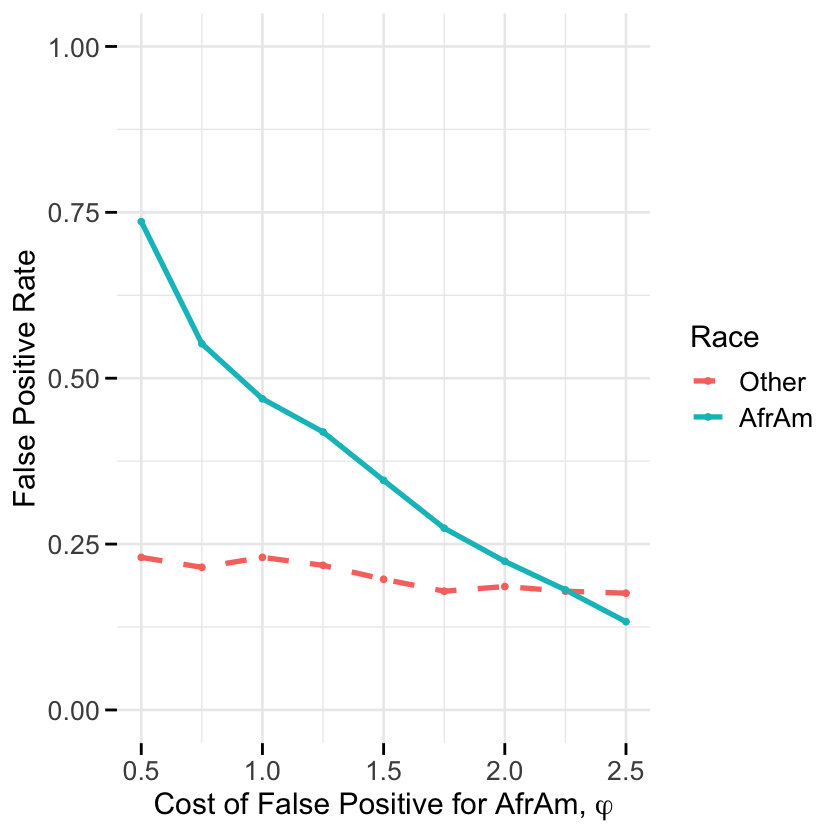

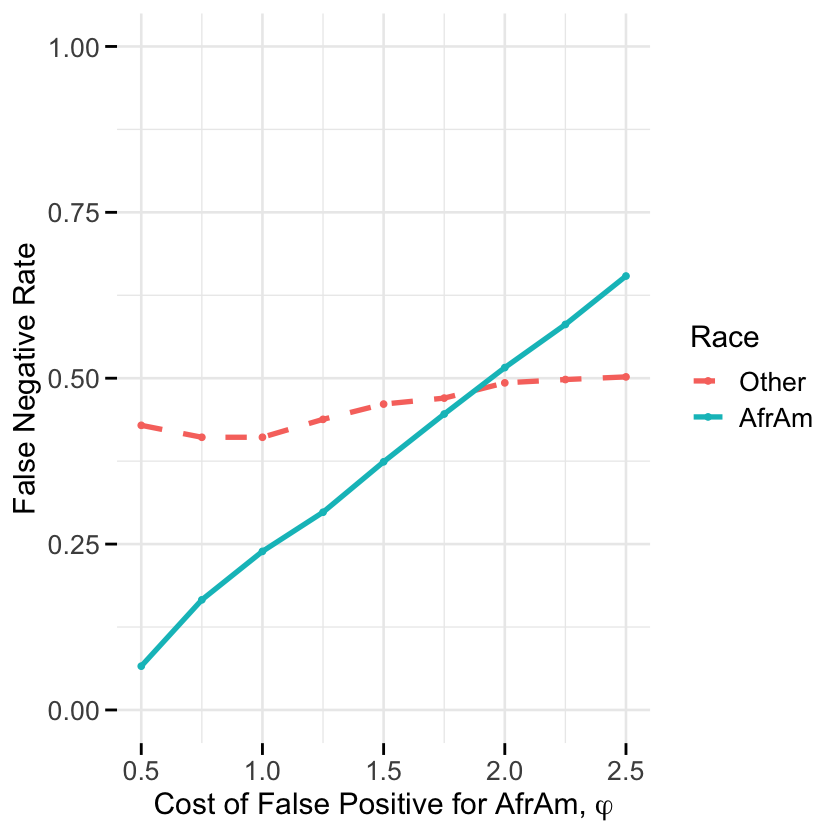

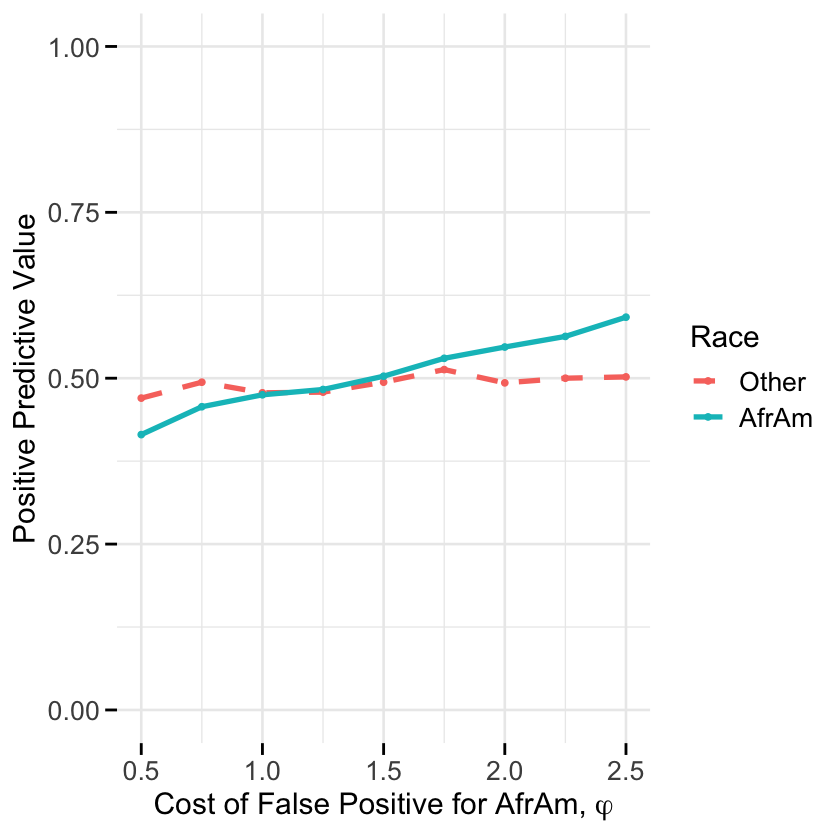

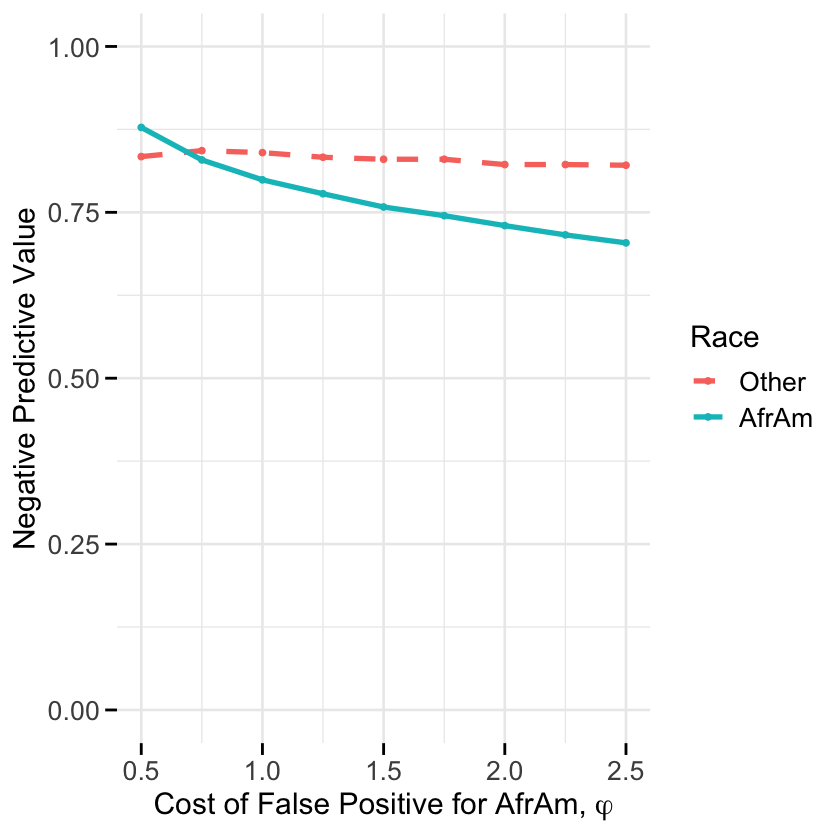

In [12]:
# Figure 6 (c): group-specific FP as a function of psi1 for Boosting
df <- data.frame(
  psi = multiplier_list,        # cost of false negative
  Other  = res_list3[, 4],
  AfrAm  = res_list3[, 10]
)
df_long <- reshape2::melt(df, id.vars = "psi", variable.name = "Race", value.name = "rate")
ggplot(df_long, aes(x = psi, y = rate, color = Race, linetype = Race)) +
  geom_line(linewidth=1.5) +
  geom_point() +
  scale_linetype_manual(values = c("Other" = "dashed", "AfrAm" = "solid")) +
  xlab(expression('Cost of False Positive for AfrAm, '*phi1)) +
  ylab('False Positive Rate') + 
  coord_cartesian(ylim = c(0, 1)) +
  big_axes
ggsave("../fig/fig_6c.pdf", plot = last_plot(), width = 9, height = 6)

# Figure 6 (d): group-specific FN as a function of psi1 for Boosting
df <- data.frame(
  psi = multiplier_list,        # cost of false negative
  Other  = res_list3[, 5],
  AfrAm  = res_list3[, 11]
)
df_long <- reshape2::melt(df, id.vars = "psi", variable.name = "Race", value.name = "rate")
ggplot(df_long, aes(x = psi, y = rate, color = Race, linetype = Race)) +
  geom_line(linewidth=1.5) +
  geom_point() +
  scale_linetype_manual(values = c("Other" = "dashed", "AfrAm" = "solid")) +
  xlab(expression('Cost of False Positive for AfrAm, '*phi1)) +
  ylab('False Negative Rate') + 
  coord_cartesian(ylim = c(0, 1)) +
  big_axes
ggsave("../fig/fig_6d.pdf", plot = last_plot(), width = 9, height = 6)

# Figure 7 (c): group-specific positive predictive value as a function of psi1 for Boosting
df <- data.frame(
  psi =multiplier_list,        # cost of false negative
  Other  = res_list3[, 7],
  AfrAm = res_list3[, 13]
)
df_long <- reshape2::melt(df, id.vars = "psi", variable.name = "Race", value.name = "rate")
ggplot(df_long, aes(x = psi, y = rate, color = Race, linetype = Race)) +
  geom_line(linewidth=1.5) +
  geom_point() +
  scale_linetype_manual(values = c("Other" = "dashed", "AfrAm" = "solid")) +
  xlab(expression('Cost of False Positive for AfrAm, '*phi1)) +
  ylab('Positive Predictive Value') + 
  coord_cartesian(ylim = c(0, 1)) +
  big_axes
ggsave("../fig/fig_7c.pdf", plot = last_plot(), width = 9, height = 6)

# Figure 7 (d): group-specific negative predictive value as a function of psi1 for Boosting
df <- data.frame(
  psi = multiplier_list,        # cost of false negative
  Other  = res_list3[, 8],
  AfrAm  = res_list3[, 14]
)
df_long <- reshape2::melt(df, id.vars = "psi", variable.name = "Race", value.name = "rate")
ggplot(df_long, aes(x = psi, y = rate, color = Race, linetype = Race)) +
  geom_line(linewidth=1.5) +
  geom_point() +
  scale_linetype_manual(values = c("Other" = "dashed", "AfrAm" = "solid")) +
  xlab(expression('Cost of False Positive for AfrAm, '*phi1)) +
  ylab('Negative Predictive Value') + 
  coord_cartesian(ylim = c(0, 1)) +
  big_axes
ggsave("../fig/fig_7d.pdf", plot = last_plot(), width = 9, height = 6)



In [13]:
# Table OA.5: Asymmetric Classifiers with Balanced FP/FN rates. 
res_list4=  matrix(0, nrow = 1, ncol = 3)

a1=c(res_list1[3,10],res_list1[3,11],res_list1[3,12])
res_list4=rbind(res_list4,a1)
a1=c(res_list1[3,4],res_list1[3,5],res_list1[3,6])
res_list4=rbind(res_list4,a1)
a1=c(res_list1[3,1],res_list1[3,2],res_list1[3,3])
res_list4=rbind(res_list4,a1)
a1=c(res_list3[3,10],res_list3[3,11],res_list3[3,12])
res_list4=rbind(res_list4,a1)
a1=c(res_list3[3,4],res_list3[3,5],res_list3[3,6])
res_list4=rbind(res_list4,a1)
a1=c(res_list3[3,1],res_list3[3,2],res_list3[3,3])
res_list4=rbind(res_list4,a1)

res_list4<-res_list4[-1,]

colnames(res_list4) <- c('FP', 'FN', 'AUC')
rownames(res_list4) <- c('African American','Others', 'all', 'African American','Others', 'all')
res_list4

# Print to LaTeX
stargazer(res_list4, type = "latex", out = "../tab/tab_oa5.tex",
          title = "Asymmetric Classifiers with Balanced FP/FN Rates",
          summary = FALSE,
          rownames = TRUE)

,FP,FN,AUC
African American,0.496,0.201,0.7216437
Others,0.215,0.425,0.7353160
all,0.344,0.297,0.7346319
African American,0.469,0.239,0.7002378
Others,0.230,0.411,0.7401945
all,0.339,0.313,0.7283656



% Table created by stargazer v.5.2.3 by Marek Hlavac, Social Policy Institute. E-mail: marek.hlavac at gmail.com
% Date and time: Sun, Oct 26, 2025 - 14:54:28
\begin{table}[!htbp] \centering 
  \caption{Asymmetric Classifiers with Balanced FP/FN Rates} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} cccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & FP & FN & AUC \\ 
\hline \\[-1.8ex] 
African.American & $0.496$ & $0.201$ & $0.722$ \\ 
Others & $0.215$ & $0.425$ & $0.735$ \\ 
all & $0.344$ & $0.297$ & $0.735$ \\ 
African.American.1 & $0.469$ & $0.239$ & $0.700$ \\ 
Others.1 & $0.230$ & $0.411$ & $0.740$ \\ 
all.1 & $0.339$ & $0.313$ & $0.728$ \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 
